# Compare the accelerometry measures of stillness
compare the ACC measure variability of many sensors in four intervals of measurement with three statistics. 

Sensors: 
 - Phone
 - AX3
 - Equivital
 - Movesense
 - Qualsys mocap
 - Video 
 
Statistics:
 - Average (std) QoM per second (cummulative normed acceleration difference/120s)
 - Average (std) QoM per sample (average normed acceleration difference)
 - Range of displacement (max of rectified difference from mean. Per dimension?)
 
Intervals:
 - Lying flat on the floor
 - Lying flat on a table
 - Standing still 1 
 - Standing still 2
 
 
 vector norm 
lying still conditions 
    (floor, table, standstill2, Stanstill1) 
steady deviance per second, 
per sample
rectified range: minus mean and rectified 
    


Clock differences


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [52]:
def min_dets(eq_file_loc): # for files output by the lab manager desktop app, so far
    filings = eq_file_loc.split('/')
    file_name = filings[-1]
    f = file_name.split('.')[0]
    dets = f.split('_')
    sensorType = dets[0]
    start_time= pd.to_datetime(dets[2],format = '%Y%m%dT%H%M%S%f')
    if sensorType in ['Equivital','Movesense']:
        start_time = start_time.tz_localize("UTC")
    if sensorType in ['Phone','AX3']:
        start_time = start_time.tz_localize("Europe/Berlin")
    if sensorType in ['Qualsys']:
        start_time = start_time.tz_localize("EET")
        
    df = pd.read_csv(eq_file_loc,index_col=0) 
    end_time= start_time+ pd.to_timedelta(df['Time'].iloc[-1],unit ='s')
    
    File_dets={'Signal':dets[1], #f[-2].split('_')[-1],
       'Sensor':sensorType, 
       'StartTime':start_time,
       'UTCstartTime':start_time.tz_convert("UTC"),
       'UTCendTime':end_time.tz_convert("UTC"),
       'FileName':file_name,
       'X' :df['X'].mean(),
       'Y' :df['Y'].mean(),
       'Z' :df['Z'].mean(),
       'FullLoc':eq_file_loc}
    return File_dets

In [53]:
path = './OUTFILES/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))
            print(file_locs[-1])
k=[]           
for f in file_locs:
    if len(f.split('_'))==3:
        File_dets=min_dets(f)
        k.append(File_dets)
df_files=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_files

./OUTFILES/Movesense_ACC_20230203T120018000.csv
./OUTFILES/Equivital_ACC_20230131T143737039.csv
./OUTFILES/Qualsys_LOC_20230131T165515333.csv
./OUTFILES/AX3_ACC_20230131T154908485.csv
./OUTFILES/Phone_ACC_20230203T124637000.csv
./OUTFILES/Movesense_ACC_20230203T114458000.csv
./OUTFILES/AX3_ACC_20230203T124319505.csv
./OUTFILES/Movesense_ACC_20230131T145727000.csv
./OUTFILES/Phone_ACC_20230131T155837000.csv
./OUTFILES/Phone_ACC_20230203T130008000.csv
./OUTFILES/Equivital_ACC_20230203T113937039.csv


,Signal,Sensor,StartTime,UTCstartTime,UTCendTime,FileName,X,Y,Z,FullLoc
0,ACC,Movesense,2023-02-03 12:00:18+00:00,2023-02-03 12:00:18+00:00,2023-02-03 12:06:24.019000+00:00,Movesense_ACC_20230203T120018000.csv,-1.473418e-01,1.018045e-01,9.742499e+00,./OUTFILES/Movesense_ACC_20230203T120018000.csv
1,ACC,Equivital,2023-01-31 14:37:37.039000+00:00,2023-01-31 14:37:37.039000+00:00,2023-01-31 15:15:52.300000+00:00,Equivital_ACC_20230131T143737039.csv,6.950539e+01,-2.323754e+02,-8.915916e+02,./OUTFILES/Equivital_ACC_20230131T143737039.csv
2,LOC,Qualsys,2023-01-31 16:55:15.333000+02:00,2023-01-31 14:55:15.333000+00:00,2023-01-31 15:08:23.849669999+00:00,Qualsys_LOC_20230131T165515333.csv,4.137860e-18,-6.513452e-19,-1.123171e-18,./OUTFILES/Qualsys_LOC_20230131T165515333.csv
3,ACC,AX3,2023-01-31 15:49:08.485000+01:00,2023-01-31 14:49:08.485000+00:00,2023-01-31 15:13:38.979000+00:00,AX3_ACC_20230131T154908485.csv,1.242981e-01,7.596565e-01,-1.081613e-01,./OUTFILES/AX3_ACC_20230131T154908485.csv
4,ACC,Phone,2023-02-03 12:46:37+01:00,2023-02-03 11:46:37+00:00,2023-02-03 11:58:12.109734+00:00,Phone_ACC_20230203T124637000.csv,-9.900544e-01,5.531115e-02,-6.604025e-02,./OUTFILES/Phone_ACC_20230203T124637000.csv
5,ACC,Movesense,2023-02-03 11:44:58+00:00,2023-02-03 11:44:58+00:00,2023-02-03 11:59:09.338000+00:00,Movesense_ACC_20230203T114458000.csv,-8.791307e-02,-9.316953e+00,2.128527e+00,./OUTFILES/Movesense_ACC_20230203T114458000.csv
6,ACC,AX3,2023-02-03 12:43:19.505000+01:00,2023-02-03 11:43:19.505000+00:00,2023-02-03 12:09:49.964000+00:00,AX3_ACC_20230203T124319505.csv,7.494074e-02,-4.350857e-01,-3.974312e-01,./OUTFILES/AX3_ACC_20230203T124319505.csv
7,ACC,Movesense,2023-01-31 14:57:27+00:00,2023-01-31 14:57:27+00:00,2023-01-31 15:09:14.260000+00:00,Movesense_ACC_20230131T145727000.csv,2.331369e-01,9.262575e+00,3.632894e+00,./OUTFILES/Movesense_ACC_20230131T145727000.csv
8,ACC,Phone,2023-01-31 15:58:37+01:00,2023-01-31 14:58:37+00:00,2023-01-31 15:08:40.720062+00:00,Phone_ACC_20230131T155837000.csv,-9.949474e-01,7.638875e-02,-1.469619e-01,./OUTFILES/Phone_ACC_20230131T155837000.csv
9,ACC,Phone,2023-02-03 13:00:08+01:00,2023-02-03 12:00:08+00:00,2023-02-03 12:06:08.401004+00:00,Phone_ACC_20230203T130008000.csv,1.320820e-03,-5.855072e-03,1.005977e+00,./OUTFILES/Phone_ACC_20230203T130008000.csv


In [20]:
df_files['Sensor'].unique()

array(['Movesense', 'Equivital', 'Qualsys', 'AX3', 'Phone'], dtype=object)

In [21]:
Time_segments={'floor':['2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:03:00.000000+00:00'],
    'table':['2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:06:00.000000+00:00'],
    'standing2':['2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:51:00.000000+00:00'],
    'standing1':['2023-01-31 15:00:00.000000+00:00','2023-01-31 15:02:00.000000+00:00']}

# '2023-01-31 15:00:00.000000+00:00','2023-01-31 15:02:00.000000+00:00'
# '2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:51:00.000000+00:00'
# '2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:03:00.000000+00:00'
# '2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:06:00.000000+00:00'

In [22]:
Time_segments.keys()

dict_keys(['floor', 'table', 'standing2', 'standing1'])

# Evaluate the gravity offset for each ACC


In [87]:
condition = 'floor'
time_int=Time_segments[condition]
s_time = pd.to_datetime(time_int[0])
e_time = pd.to_datetime(time_int[1])
[s_time,e_time]

[Timestamp('2023-02-03 12:01:00+0000', tz='UTC'),
 Timestamp('2023-02-03 12:03:00+0000', tz='UTC')]

In [88]:
seg_sens = {}
for i,row in df_files.iterrows():
    if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
        start_time = row['StartTime'].tz_convert("UTC")
        
        df = pd.read_csv(row['FullLoc'],index_col=0)
        df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
        df.set_index(df['DateTime'],inplace=True,drop=True)        
        cols = df.columns
        
        X = df.loc[df.index>s_time,:].copy()
        X = X.loc[X.index<e_time,:].copy()
        seg_sens[row['Sensor']] = X.loc[:,['X', 'Y', 'Z']].copy()

,Signal,Hz,X,Y,Z,g
0,AX3,194.855807,-0.009510,0.000644,-1.010405,1.010485
1,Equivital,25.600328,76.475260,972.411458,-52.803060,976.849969
2,Movesense,210.570646,-0.137610,0.125925,9.741877,9.743707
3,Phone,20.040482,0.001323,-0.008818,1.006006,1.006048


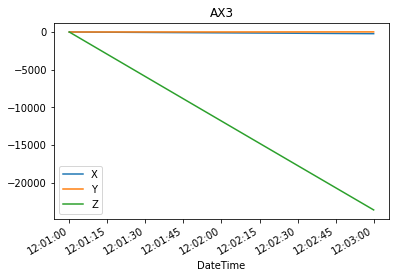

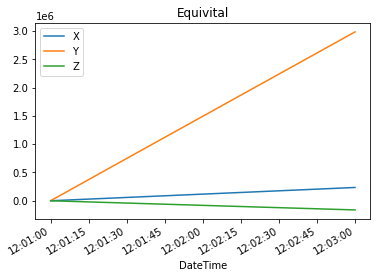

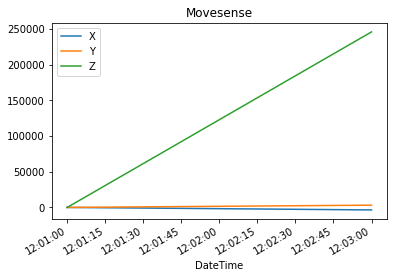

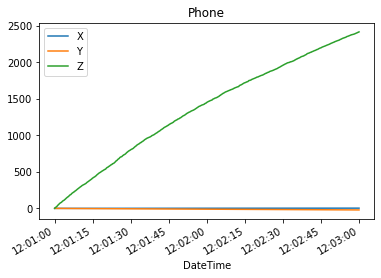

In [89]:
k=[]           

for sensor in ['AX3','Equivital', 'Movesense', 'Phone']:
    clip = seg_sens[sensor]
    qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
    seg_dets={'Signal':sensor,
              'Hz':1/pd.Series(clip.index).diff().mean().total_seconds(),
              'X' :clip['X'].mean(),
              'Y' :clip['Y'].mean(),
              'Z' :clip['Z'].mean(),
              'g': np.sqrt(np.square(clip).sum(axis=1)).mean(),
             }
    clip.cumsum().plot()
    plt.title(sensor)
    k.append(seg_dets)
plt.legend()
              
df_segStats=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_segStats

In [90]:
print(df_segStats.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &     Signal &          Hz &          X &           Y &          Z &           g \\
\midrule
0 &        AX3 &  194.855807 &  -0.009510 &    0.000644 &  -1.010405 &    1.010485 \\
1 &  Equivital &   25.600328 &  76.475260 &  972.411458 & -52.803060 &  976.849969 \\
2 &  Movesense &  210.570646 &  -0.137610 &    0.125925 &   9.741877 &    9.743707 \\
3 &      Phone &   20.040482 &   0.001323 &   -0.008818 &   1.006006 &    1.006048 \\
\bottomrule
\end{tabular}



The four accelerometers report values in different scales. To get a check on the different scales, we calculate the average total acceleration in the floor recording. In this time, the main force acting on each device is gravity. No matter the orientation of the device, the norm of acceleration should equal g (9.8 m/s^2). 

AX3 and Phone appear to normalise the recorded values byt g, giving average acceleration of 1, or nearly.

Movesense has g very near the metric units of 9.8 m/s^2. Equivital seens to have a value close to g but with a factor of 100 to scale acceleration to vary meaningfully within the discrete integer range of +/- 1024 (or similar value).  

We take the g values per device during the floor condition to scale each device acc values to have a g of 1. 

There is sadly no way to extend this estimate the qualisys measurements. A preliminary factor of 9.8 on the double difference gives values within a similar range to the other sensors, but this alone does not validate this wild, unvarified adjustment. 

In [61]:
# from the floor measurements get estimate of gravity constant in the devices units
# this is used to linearly scale all the clips. 
grav_factor = {'Movesense':9.743707, 'Equivital':976.849969, 'Qualsys':9.8, 'AX3':1.010485, 'Phone':1.006048}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

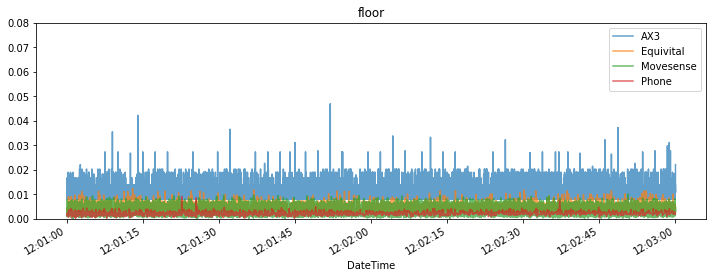

      Signal          Hz  QoM Mean   QoM STD   QoM Max   Dis Sec
0        AX3  194.855807  0.010686  0.002747  0.046994  2.469106
1  Equivital   25.600328  0.004897  0.001929  0.012365  0.165683
2  Movesense  210.570646  0.003484  0.001473  0.010076  1.017728
3      Phone   20.040482  0.002228  0.000759  0.009168  0.062824


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

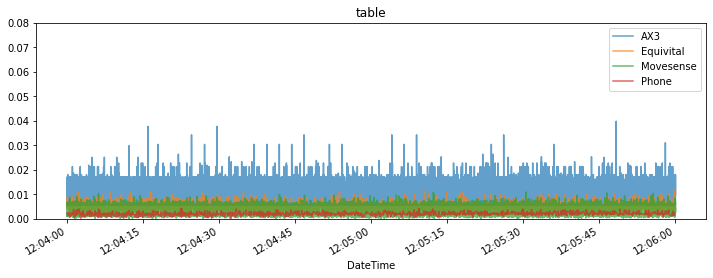

      Signal          Hz  QoM Mean   QoM STD   QoM Max   Dis Sec
0        AX3  195.045836  0.008439  0.003718  0.039868  1.861102
1  Equivital   25.600328  0.004665  0.002035  0.011721  0.161743
2  Movesense  210.614996  0.003410  0.001448  0.010952  1.008844
3      Phone   13.425161  0.002039  0.000649  0.004310  0.036588


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

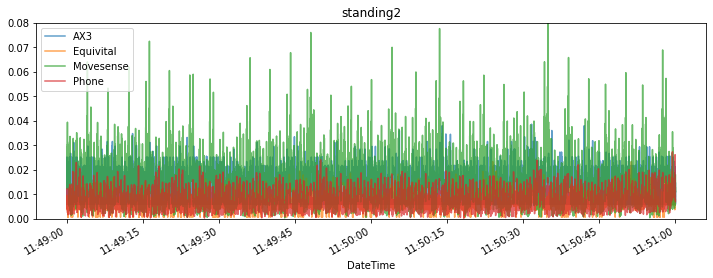

      Signal          Hz  QoM Mean   QoM STD   QoM Max   Dis Sec
0        AX3  195.083886  0.011351  0.005284  0.038656  2.047261
1  Equivital   25.600328  0.007156  0.003404  0.023382  0.228738
2  Movesense  210.570646  0.015329  0.008670  0.081199  1.256410
3      Phone   48.473097  0.007123  0.003856  0.027360  0.326441


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

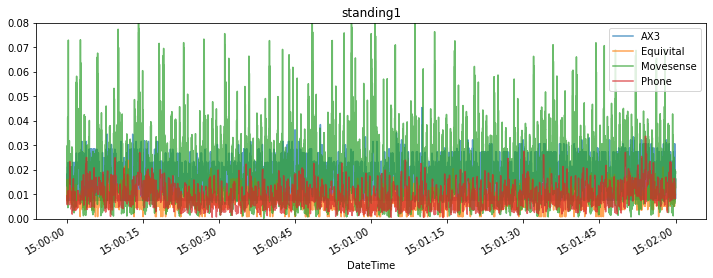

      Signal          Hz  QoM Mean   QoM STD   QoM Max   Dis Sec
0        AX3  200.843543  0.011955  0.005879  0.045452  1.737981
1  Equivital   25.600328  0.008011  0.003595  0.023989  0.205653
2  Movesense  210.570646  0.018869  0.010143  0.084256  1.510297
3      Phone   16.670001  0.009099  0.004758  0.033776  0.167357


In [80]:
for condition in Time_segments.keys():
    time_int=Time_segments[condition]
    s_time = pd.to_datetime(time_int[0])
    e_time = pd.to_datetime(time_int[1])

    seg_sens = {}
    for i,row in df_files.iterrows():
        if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
            start_time = row['StartTime'].tz_convert("UTC")
            df = pd.read_csv(row['FullLoc'],index_col=0)
            df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
            df.set_index(df['DateTime'],inplace=True,drop=True)        
            cols = df.columns
            X = df.loc[df.index>s_time,:].copy()
            X = X.loc[X.index<e_time,:].copy()
            seg_sens[row['Sensor']] = X.loc[:,['X', 'Y', 'Z']].copy()/grav_factor[row['Sensor']]

    k=[]           
    fig = plt.figure(figsize=(12,4))
    for sensor in ['AX3','Equivital','Movesense','Phone']: #seg_sens.keys():
        clip = seg_sens[sensor]
        qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
        seg_dets={'Signal':sensor,
                  'Hz':1/pd.Series(clip.index).diff().mean().total_seconds(),
                  'QoM Mean': qom.mean(),
                  'QoM STD': qom.std(),
                  'QoM Max': qom.max(), #np.sqrt(np.square(clip - clip.mean()).sum(axis=1)).max(),
                  'Dis Sec':np.sqrt(np.square(clip.diff()).sum(axis=1)).sum()/120,
                 }
        qom.plot(alpha = 0.7,label=sensor)
        #clip['Z'].plot(label=sensor)
        
        k.append(seg_dets)
    plt.legend()
    plt.title(condition)
    plt.ylim([0,0.08])
    plt.savefig(condition+'_standardized_qom.eps',format = 'eps',bbox_inches = 'tight',dpi = 300)
    plt.show()
    
    df_segStats=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
    print(df_segStats)

In [84]:
df_stats = pd.DataFrame(index = ['AX3','Equivital', 'Movesense', 'Phone'],columns = ['floor','table','standing1','standing2'])

for condition in Time_segments.keys():
    time_int=Time_segments[condition]
    s_time = pd.to_datetime(time_int[0])
    e_time = pd.to_datetime(time_int[1])

    seg_sens = {}
    for i,row in df_files.iterrows():
        if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
            start_time = row['StartTime'].tz_convert("UTC")
            df = pd.read_csv(row['FullLoc'],index_col=0)
            df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
            df.set_index(df['DateTime'],inplace=True,drop=True)        
            cols = df.columns
            X = df.loc[df.index>s_time,:].copy()
            X = X.loc[X.index<e_time,:].copy()
            clip = X.loc[:,['X', 'Y', 'Z']].copy()/grav_factor[row['Sensor']]
            qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
            st = qom.mean()
            
            df_stats.loc[row['Sensor'],condition] = str(np.round(qom.mean(),4)) + ' ('+str(np.round(qom.std(),3))+', m '+str(np.round(qom.max(),3))+')'

df_stats

,floor,table,standing1,standing2
AX3,"0.0107 (0.003, m 0.047)","0.0084 (0.004, m 0.04)","0.012 (0.006, m 0.045)","0.0114 (0.005, m 0.039)"
Equivital,"0.0049 (0.002, m 0.012)","0.0047 (0.002, m 0.012)","0.008 (0.004, m 0.024)","0.0072 (0.003, m 0.023)"
Movesense,"0.0035 (0.001, m 0.01)","0.0034 (0.001, m 0.011)","0.0189 (0.01, m 0.084)","0.0153 (0.009, m 0.081)"
Phone,"0.0022 (0.001, m 0.009)","0.002 (0.001, m 0.004)","0.0091 (0.005, m 0.034)","0.0071 (0.004, m 0.027)"
Qualsys,NaN,NaN,"0.0085 (0.007, m 0.076)",NaN


In [85]:
print(df_stats.to_latex())

\begin{tabular}{lllll}
\toprule
{} &                    floor &                    table &                standing1 &                standing2 \\
\midrule
AX3       &  0.0107 (0.003, m 0.047) &   0.0084 (0.004, m 0.04) &   0.012 (0.006, m 0.045) &  0.0114 (0.005, m 0.039) \\
Equivital &  0.0049 (0.002, m 0.012) &  0.0047 (0.002, m 0.012) &   0.008 (0.004, m 0.024) &  0.0072 (0.003, m 0.023) \\
Movesense &   0.0035 (0.001, m 0.01) &  0.0034 (0.001, m 0.011) &   0.0189 (0.01, m 0.084) &  0.0153 (0.009, m 0.081) \\
Phone     &  0.0022 (0.001, m 0.009) &   0.002 (0.001, m 0.004) &  0.0091 (0.005, m 0.034) &  0.0071 (0.004, m 0.027) \\
Qualsys   &                      NaN &                      NaN &  0.0085 (0.007, m 0.076) &                      NaN \\
\bottomrule
\end{tabular}



In [83]:
df_stats.columns

MultiIndex([(    'floor',),
            (    'table',),
            ('standing2',),
            ('standing1',)],
           )